In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv


# Natural Language Processing - Disaster Tweets

## Introduction

This is a beginner's approach and key must have steps for a NLP project. The style is very generic for text cleaning and vectorization. The choice of model is based on cross validation and how a simple model with no bells and whistles can lead to a good f1-score. Try out various other models if you find this approach suitable. The key is not to be overwhelmed by the amount of regex operations one would like to do. This is kept minimal in this notebook where regex is applied only to get rid of the urls. Lastly, I am very grateful to some of the kagglers who went on to share their work on the same project.

## Load the Libraries
Load the usual ones that would be used. Specific library imports done at the place where it is used. That way it helps in maintaining the flow. 

In [2]:
# usual imports 
import pandas as pd
import numpy as np
import sys
import os
import random

# assert the python version
assert sys.version_info >= (3,5)

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# consistent plot size unless specified 
from pylab import rcParams
rcParams['figure.figsize'] = 12,7
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12

# handle unwanted warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

# NLP / Text specific imports
import nltk
import spacy
nlp = spacy.load('en_core_web_sm',disable=['parser','tagger','ner'])

# NLP - Text Cleaning
from nltk.tokenize import word_tokenize
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Word Cloud
from wordcloud import WordCloud

# text vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# regular expression
import re

# string operations
import string

# ML Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# cross validation
from sklearn.model_selection import cross_val_score,cross_val_predict,KFold,RepeatedStratifiedKFold

# Model Fine Tuning
from sklearn.model_selection import GridSearchCV

# Pipeline
from sklearn.pipeline import Pipeline

# keras
from keras.utils import to_categorical

# Model evaluation metrics
from sklearn.metrics import classification_report,f1_score,accuracy_score,precision_score,recall_score

## Load the data
The dataset consists of train csv and test csv

### Load as Pandas Dataframe

In [3]:
# check the subdirectories under the root folder
gen = os.walk('/kaggle/input')
next(gen)

('/kaggle/input', ['nlp-getting-started'], [])

In [4]:
%%time
# load the train and test data
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
print(f'Train Data Size {train.shape}')

Train Data Size (7613, 5)
CPU times: user 26.6 ms, sys: 7.36 ms, total: 34 ms
Wall time: 42.3 ms


## Data Exploration
Understand and visualize the data

In [5]:
# check few rows 
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [7]:
train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### See the full tweets randomly


In [9]:
# Print out the full tweet of a few rows
import random
for i in range(3):
    row = random.randint(0,len(train))
    print(f'Tweet at Row {row}')
    print(train['text'].loc[row])
    print('\n')

Tweet at Row 116
320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/e14EPzhotH | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/22a9D5DO6q


Tweet at Row 2661
.@no_periferico Apollo Brown - 'Detonate' f. M.O.P. http://t.co/m7na4sKfWR #ORapInforma


Tweet at Row 4206
8/6/2015@1:32 PM: HAZARD IN HIGH TRAFFIC AREA at 5000 DEANS BRIDGE RD http://t.co/itZzKWfhG5




As expected, the tweets contain hashtags, links etc. There is a pattern across all tweets. All the tweets contain one of the strong words which represent or highlight a special situation. A few of the examples of these words are 'emergency', 'electrocute', 'bleeding','guilty', 'crash' , 'windstorm', 'snowstorm' and a lot more. 

### Check for data balance

In [10]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

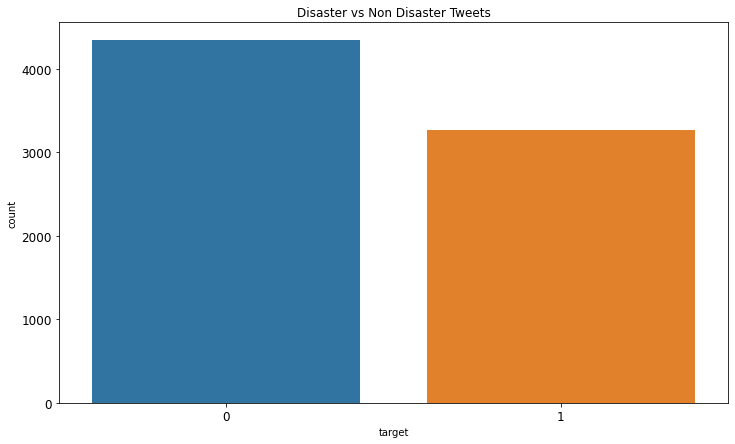

In [11]:
sns.countplot(train['target'])
plt.title('Disaster vs Non Disaster Tweets');

The dataset is fairly balanced. Will reserve synthetic generation of data using techniques like SMOTE or ADASYN for performance tuning if needed.

In [12]:
# Add a new column to make the target more explicit 
train['disaster'] =  train['target'].apply(lambda x: 'real' if x ==1 else 'not real')

Text(0.5, 1.0, 'Disaster vs Non Disaster Tweets')

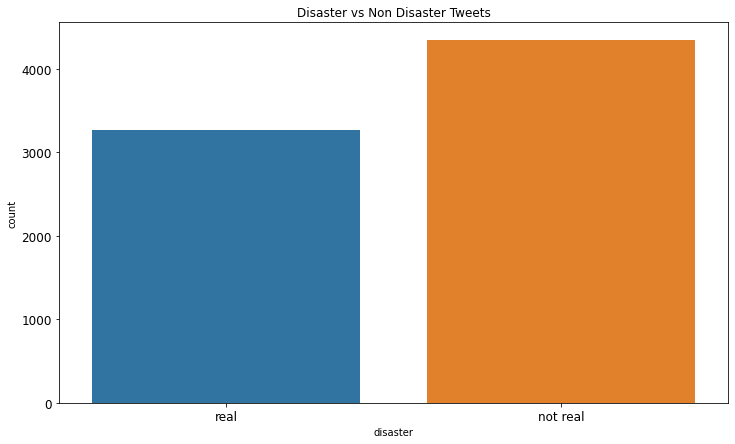

In [13]:
# Plot the same graph as earlier but on the newly created column --> more intuitive
sns.countplot(train['disaster'])
plt.title('Disaster vs Non Disaster Tweets')

There are more data points for not real disaster tweets than the real disaster tweets. 

### Check for empty tweets

In [14]:
# Code section to create a lis of indices where there are empty tweets
blanks = []

for idx,id_,kwd,loc,txt,tgt,dis in train.itertuples():
    if type(txt) == str:
        if txt.isspace():
            blanks.append(idx)
print (f'The list of indices where there are blank tweets is {blanks}')

The list of indices where there are blank tweets is []


Cool, there are no blank tweets or empty strings in the text column. Had it been there, I would choose to drop them from analysis.

### Check for missing values

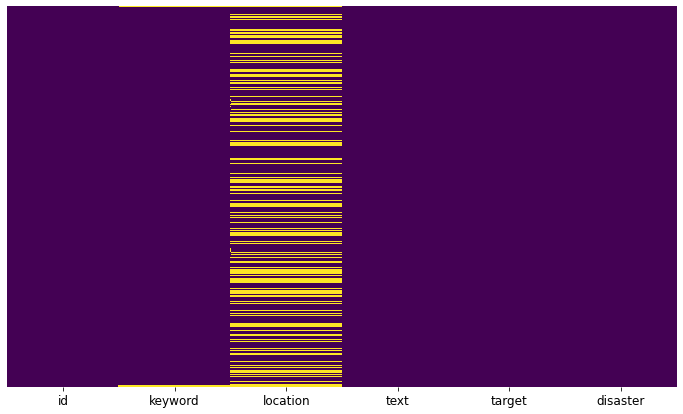

In [15]:
# heatmap to visualize the missing values
sns.heatmap(train.isnull(),cbar=False,yticklabels=False,cmap='viridis');

The heatmap makes the missing values transparent by highlighting them with a separate color. Location has a lot of missing values. Keyword also has a lot of missing values but have to look closely. Let's check as well numerically.

In [16]:
# missing values in train set
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
disaster       0
dtype: int64

There are only 61 rows with missing keyword out of over 7000 tweets. The location is missing for roughly 40% of the tweets. 

In [17]:
# check for missing values in test set
test.isna().sum()


id             0
keyword       26
location    1105
text           0
dtype: int64

The result is similar in the test dataset. The missing keyword is relatively very low compared to the total tweets. Perhaps dropping them off from the dataset wouldn't cause much damage. The location is missing for over 30% of the total tweets in the test data. Anyway, we do not want to explore the test dataset and keep it as hidden as possible. All transformation, vectorization applied on the training data would be applied on the test data later on.

### Understand the keyword and the relation with tweets

In [18]:
# Randomly pick a few rows and print the keyword and the corresponding tweet 
for i in range(5): # check any 5 random keywords
    row = random.randint(0,len(train))
    
    if train['keyword'].loc[row].isspace():  # to handle the missing keywords
        print('Nothing to print')
        
    else:  # print the keyword and the corresponding text
        print(f'keyword at Row {row}:-')
        print(train['keyword'].loc[row])
        print('The full tweet text is :-')
        print(train['text'].loc[row])
        print('\n')

keyword at Row 5920:-
screamed
The full tweet text is :-
I heard the steven universe theme song from upstairs and screamed his name at the part of the song and scared my cousin


keyword at Row 721:-
bleeding
The full tweet text is :-
Eating takis then rubbing my eyes with my hands now my eyes are bleeding tears


keyword at Row 4878:-
massacre
The full tweet text is :-
@Cameron_WATE
 Parents of Colorado theater shooting victim fear copycat massacre

http://t.co/LvlH3W3aWO
#Antioch

http://t.co/vIwXY1XDYK


keyword at Row 2722:-
devastated
The full tweet text is :-
Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for Northern Marians a... http://t.co/JCszCJiHlH


keyword at Row 6364:-
suicide%20bomb
The full tweet text is :-
Pic of 16yr old PKK suicide bomber who detonated bomb in Turkey Army trench released http://t.co/1yB8SiZarG http://t.co/69iIzvyQYC




The keyword column contains the strong words that signify disaster. The word exists in the text of the tweets and the real context of the word can only be ascertained from the full tweets. 

### Which tweets have missing keywords more - real or not real ? 

In [19]:
train[train['keyword'].isna()]['disaster'].value_counts()

real        42
not real    19
Name: disaster, dtype: int64

Real has comparatively more missing keywords than the non real ones. 

### Which keywords are repeated more often ? 

In [20]:
# get the keywords  --> top_kwd will be the series containing all the keywords sorted in the descending order of occurrence
top_kwd = train['keyword'].value_counts()

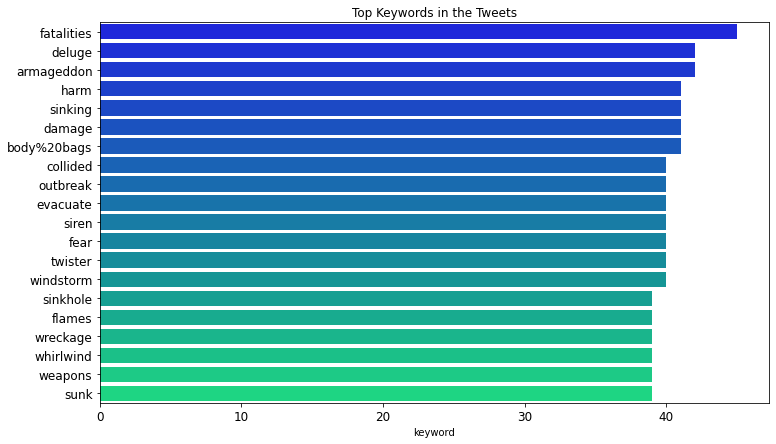

In [21]:
sns.barplot(y=top_kwd[:20].index,x=top_kwd[:20],palette='winter')
plt.title('Top Keywords in the Tweets');

A quick glance at the top keywords clearly indicates the vocab used while tweeting  for a disaster. However, it does not reflect whether it is associated with a real disaster or not. 

### Which keywords are the least used ? 

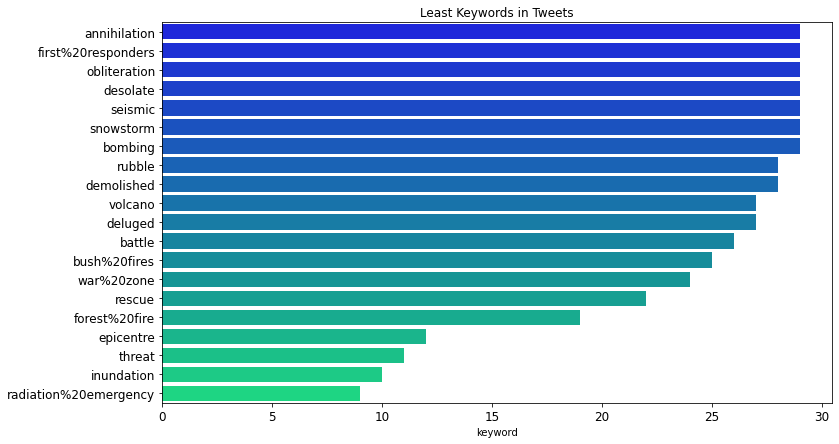

In [22]:
sns.barplot(y=top_kwd[-20:].index,x=top_kwd[-20:],palette='winter')
plt.title('Least Keywords in Tweets');

In [23]:
# total unique keywords
len(train['keyword'].unique())

222

222 unique keywords is quite a lot. By the way, there are also occurences where there are multiple keywords. 

### Print out the full tweet for a few samples where the keyword is missing

In [24]:
num_ = 3
for i in range(num_):
    print('Example {}'.format(i+1))
    print('Tweet of Missing keyword and Real Disaster')
    print(train[train['keyword'].isna() & train['target']==1]['text'].iloc[i])
    print('Tweet of Missing keyword and Not Real Disaster')
    print(train[train['keyword'].isna() & train['target']==0]['text'].iloc[i])
    print('\n')

Example 1
Tweet of Missing keyword and Real Disaster
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Tweet of Missing keyword and Not Real Disaster
What's up man?


Example 2
Tweet of Missing keyword and Real Disaster
Forest fire near La Ronge Sask. Canada
Tweet of Missing keyword and Not Real Disaster
I love fruits


Example 3
Tweet of Missing keyword and Real Disaster
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
Tweet of Missing keyword and Not Real Disaster
Summer is lovely




Disaster tweets seem to look longer than the non disaster ones. Lets visualize this out.

### Number of words in the tweets
Here I must mention that I took inspiration from the notebook https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove for the two visualizations below. 

In [25]:
# function for word count 
def tweet_len(string):
    if type(string)==str:
        string_list = string.split()
        return len(string_list)

In [26]:
train['tweet_length'] = train['text'].apply(tweet_len)

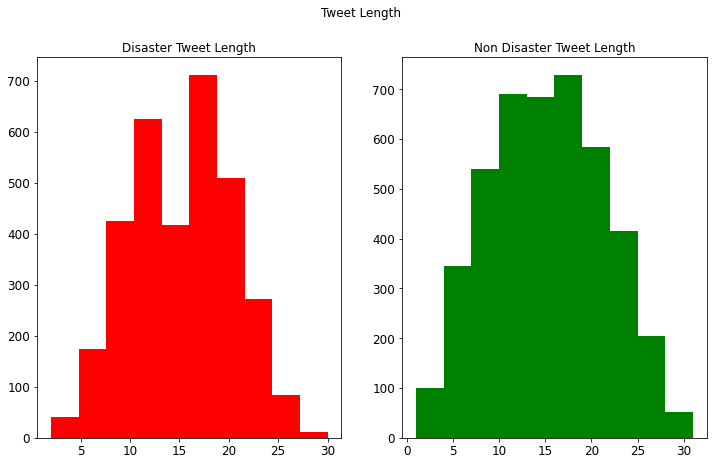

In [27]:
# Histogram of the tweet length
fig,(ax1,ax2)= plt.subplots(1,2)
tweet_length_1 =  train[train['target']==1]['tweet_length']
ax1.hist(tweet_length_1,color='red');
ax1.set_title('Disaster Tweet Length')

tweet_length_0 =  train[train['target']==0]['tweet_length']
ax2.hist(tweet_length_0,color='green')
ax2.set_title('Non Disaster Tweet Length')
fig.suptitle('Tweet Length');

Both the disaster and non disaster tweets have similar number of words in their tweets, between 15 to 20.

### Average word length in the tweet
Generally, in tweets there are repetitions of the same character, e.g woooooowwww, LOOOOOOOOOOOOOOOOL etc. Usually for disaster tweets, I expect people would try to stress on the urgency by stretching a particular character. 

In [28]:
# function for word count 
def avg_word_len(text):
     # split the tweet text per row on space and create a word list   
    if type(text)==str:
        word_list = text.split()
        word_len = []
        # compute the average length of word per tweet text --> text is uncleaned, so all characters will be counted
        for word in word_list:            
            word_len.append(len(word))
            avg_word_len_text = sum(word_len)/len(word_list)
        return avg_word_len_text    

In [29]:
# create a new column to store the average word length per tweet
train['avg_word_len'] = train['text'].apply(avg_word_len)
train['avg_word_len'] = round(train['avg_word_len'],1)

In [30]:
train.head()

,id,keyword,location,text,target,disaster,tweet_length,avg_word_len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,real,13,4.4
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,real,7,4.6
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,real,22,5.1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,real,8,7.1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,real,16,4.5


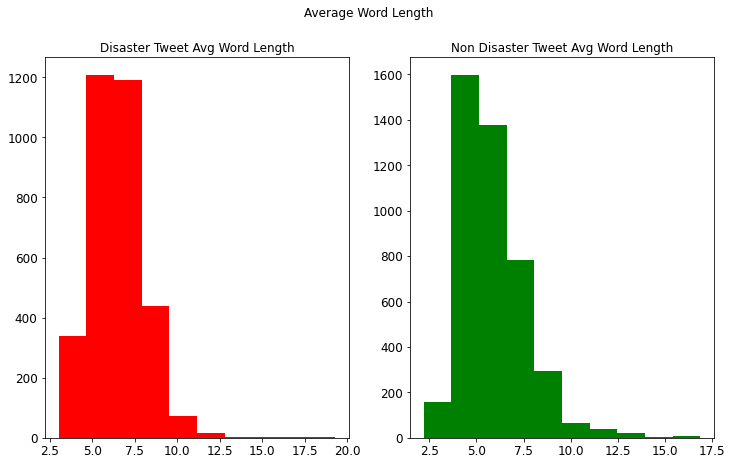

In [31]:
# Histogram of the average character length --> at this point counts special character and digits
fig,(ax1,ax2)= plt.subplots(1,2)
word_length_1 =  train[train['target']==1]['avg_word_len']
ax1.hist(word_length_1,color='red');
ax1.set_title('Disaster Tweet Avg Word Length')

word_length_0 =  train[train['target']==0]['avg_word_len']
ax2.hist(word_length_0,color='green')
ax2.set_title('Non Disaster Tweet Avg Word Length')
fig.suptitle('Average Word Length');

There is no clear cut distinction in terms of the avg length of the characters in the real and non real disaster tweets. Both of them have median value between 5 and 7.5 character length. 

### Exploring the location feature

In [32]:
# top 10 locations
train['location'].value_counts()[:10]

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Name: location, dtype: int64

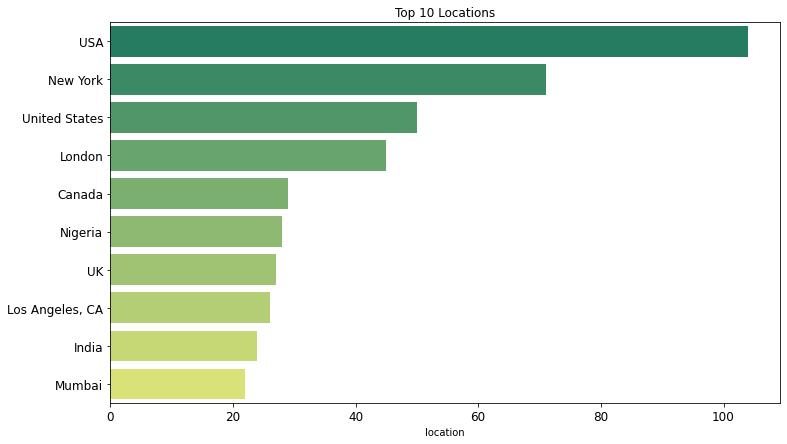

In [33]:
# plot the top 10 locations
sns.barplot(y=train['location'].value_counts()[:10].index,x=train['location'].value_counts()[:10],palette='summer')
plt.title('Top 10 Locations');

USA tops the list in disaster tweets. India is at the 9th position but Mumbai city in India has its own number of disaster tweets. If we combine the cities and their countries, the overall position would differ from what we have now. USA and United States are the same. Perhaps we should combine them into one.

In [34]:
train['location']= train['location'].apply(lambda x: 'USA' if x=='United States' else x)

In [35]:
train['location'].value_counts()[:10] # we should not see United States now

USA                154
New York            71
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Name: location, dtype: int64

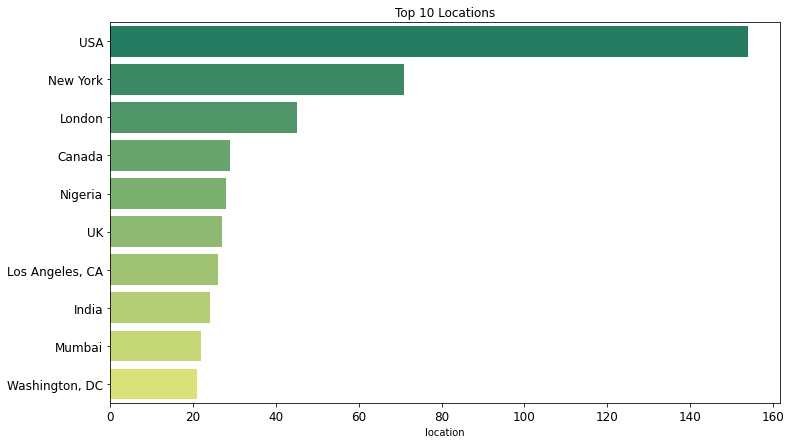

In [36]:
# plot the top 10 locations
sns.barplot(y=train['location'].value_counts()[:10].index,x=train['location'].value_counts()[:10],palette='summer')
plt.title('Top 10 Locations');

In [37]:
train['location'].unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

## Standardize the location 
Here I will make use of the code block from https://www.kaggle.com/parulpandey/getting-started-with-nlp-a-general-intro 

I added a few more places Washington, DC instead of Washington, D.C. and Sacramento, CA to USA and many others. This is also not a complete replacement. 

In [38]:
train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, DC":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                           'Sacramento, CA':'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                           "Dallas, TX":'USA',
                           "Nashville, TN":'USA',
                           'Denver, Colorado':'USA',
                            "Mumbai":"India"},inplace=True)

### Plot the location after cleaning


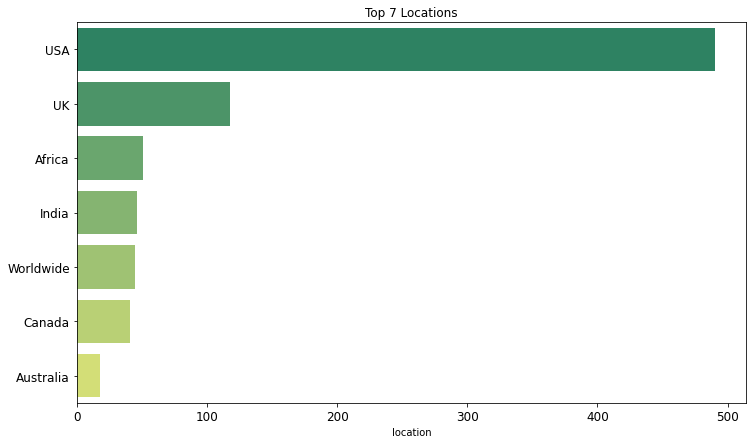

In [39]:
# plot the top 10 locations
sns.barplot(y=train['location'].value_counts()[:7].index,x=train['location'].value_counts()[:7],palette='summer')
plt.title('Top 7 Locations');

Now India climbs to the 3rd position. I have no clue which place is represented by "ss"

### Data Exploration summary
- The dataset has missing values. Location column has roughly 40% missing values. 
- Keywords are the strong words which are typically used in disaster or a catastrophe. It need not be associated     with a natural real occurence of a disaster. 
- There are a few missing keywords, totally 61 with real disaster tweets with 42 and remaining to non real           disaster. 
- The exploration of the number of words and avg word per tweet --> no clear distinction for a real or a non real tweet. These features are added as additional columns and might be handy for improving the predictability of the model.
- Location clean up and plot indicated the countries from where the maximum tweets came from. 

## Text Cleaning

Define functions to take care of the following. 

- Remove the urls and weblinks
- Split into sentences
- Split into words
- Filter out Punctuation
- Filter out Stop Words
- Stem Words
- Lemmatization

### Remove URL's

In [40]:
def rem_url(text):
    '''This function removes the urls from the text. Alternatively use lambda functions'''
    new_text = re.sub(r'http\S+','',text) 
    new_text = re.sub(r'@\S+','',new_text) # get rid of all the name referrals as in @prakhar
    return new_text 

### Split into Sentences

In [41]:
def sent_text(text):
    '''This function will return the sentences from the tweets'''
    sentences = sent_tokenize(text)
    return sentences

### Split into words
Before splitting into words, we need to make the text in lower case. Additionally, the punctuations will also be filtered out.

In [42]:
def to_lower(text):
    ''' Convert the string to lower case'''
    ## first split on spaces 
    text_split = text.split()
    word_list = []
    
    for word in text_split:        
        if type(word) == str:
            word_ = word.lower()
            word_list.append(word_)
        new_text = ' '.join(word_list)
    return new_text     
    

In [43]:
def split_words(text):
    '''This function splits the sentences into words and filters out the punctuations'''
    tokens = word_tokenize(text)
    # filter out the punctuations
    words = [word for word in tokens if word.isalpha()]
    return words

### Filter out the Stop Words

In [44]:
def stop_word(text):
    '''This function will filter out the stop words from the word tokens'''
    stop_words = set(stopwords.words('english'))
    words = [word for word in text if not word in stop_words]
    return words

### Stemming

In [45]:
def stem_word(text):
    '''This function performs stemming -- Returns the root form of the word'''
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in text]
    return stemmed

In [46]:
def lemma_word(text):
    '''This function performs lemmatization'''
    lemmatizer = WordNetLemmatizer()
    word_lemma = [lemmatizer.lemmatize(word) for word in text]
    return word_lemma

### Join the list to form the cleaned text

In [47]:
def join_list(text):
    '''This function will perform the join operation'''
    join_text = ' '.join(text)
    return join_text

### Clean the text in the train and test dataset 
After having defined these functions, it is time to apply them to the text of train and test dataset. The advantage of these functions is that I can reuse them for my other NLP projects. In many of the cases, this could have been realized in a single line of code using the capabilities of lamdba expressions in Python. 

We will do this by creating a list of all the cleaning functions we would like to apply on the text. I chose not to include stemming but rather picked up lemmatization. 

In [48]:
clean_fun_list =  [to_lower,rem_url,split_words,stop_word,lemma_word,join_list]

for function in clean_fun_list:
    train['text'] = train['text'].apply(function)
    test['text'] = test['text'].apply(function)
    
# print a sample of cleaned text 
print(train['text'][random.randint(0,len(train))])


heart attack thought goat dead worry rocket okay


## WordCloud
An NLP project without a word cloud always seems incomplete. Let's see how the word cloud looks like after the text cleaning has been applied.

From the wordcloud,it is not very clear what the word amp means. It occurs in both the disaster as well as in non disaster tweets. Probably a result of the cleaning of the text where the context is broken. Probably  it is a short hand for words like 'amplified', 'amplifier'. 

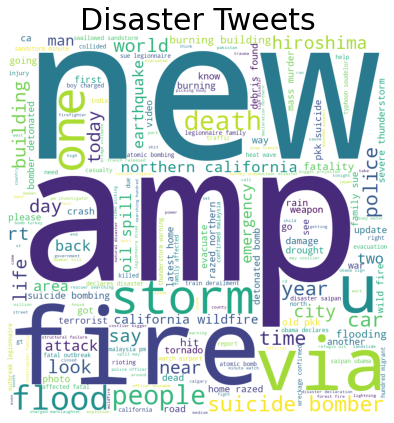

In [49]:
real_disaster = train[train['target']==1]['text']
non_disaster = train[train['target']==0]['text']

disaster_wordcloud = WordCloud( background_color='white',
                        width=900,
                        height=900).generate(' '.join(real_disaster))

plt.title('Disaster Tweets',fontsize=30)
plt.axis('off')
plt.imshow(disaster_wordcloud);

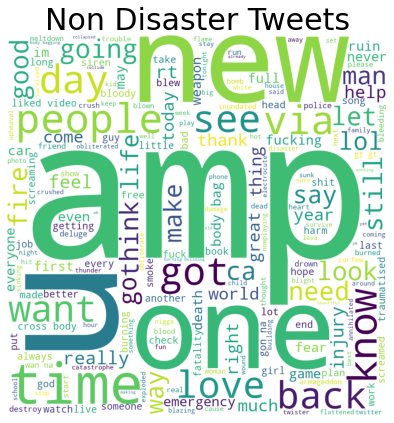

In [50]:
non_disaster_wordcloud = WordCloud( background_color='white',
                        width=900,
                        height=900).generate(' '.join(non_disaster))

plt.title('Non Disaster Tweets',fontsize=30)
plt.axis('off')
plt.imshow(non_disaster_wordcloud);


## Split into train and vaidation dataset
In this step, before applying the text vectorization it is better to split the training dataset into train and validation set and test the various models. The best model will be selected for predicting on the test dataset. 

In [51]:
X = train['text']
y = train['target']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [52]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6090,), (6090,), (1523,), (1523,))

## Text Vectorization
We will make use of the TfidfVectorizer which combines the steps of Count vectorizer and TfidfTransformer. 

In [53]:
tfidf = TfidfVectorizer(min_df=2,max_df=0.95,ngram_range=(1,2))

In [54]:
X_train = tfidf.fit_transform(X_train)
#y_train = to_categorical(y_train)

In [55]:
X_test = tfidf.transform(X_test)
#y_test = to_categorical(y_test)

## Cross Validation
We will make use of the RepeatedStratifiedKFold.
For more information check this link https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html

In [56]:
def cross_validate(X=X_train,y=y_train):
    '''This function will test various models using cross validation and 
       prints out the mean and standard deviation. The best performing model will be 
       used for further fine tuning using Grid search. Due to time constraint, ensemble techniques have been
       excluded.'''
    
    warnings.filterwarnings(action='ignore',message='')
    
    # create a list of models to be cross validated
    models = []
    models.append(('Naive Bayes',MultinomialNB()))
    models.append(('Logistic Regression',LogisticRegression()))
    #models.append(('Random Forest',RandomForestClassifier()))
    #models.append(('Gradient Boosting',GradientBoostingClassifier()))
    #models.append(('XG Boost',XGBClassifier()))
    models.append(('Linear SVC',LinearSVC()))
    models.append(('Decision Tree',DecisionTreeClassifier()))
    
    results = []
    names = []
    scoring = 'f1'
    
    # Cross validate all the models in the list and print the mean and std deviation of the f1 score. 
    for name,model in models:
        kfold = RepeatedStratifiedKFold(random_state=42,n_repeats=10,n_splits=5)
        cv_results = cross_val_score(model,X,y,cv=kfold,scoring=scoring)
        results.append(cv_results)
        names.append(name)
        print (f'Model:{name},Mean:{cv_results.mean()},Std Dev: {cv_results.std()}')      
    

In [57]:
cross_validate(X_train,y_train)

Model:Naive Bayes,Mean:0.7301436473165971,Std Dev: 0.01252413186651894
Model:Logistic Regression,Mean:0.7324805931833839,Std Dev: 0.01205151971133231
Model:Linear SVC,Mean:0.7277150269916446,Std Dev: 0.01306281911261712
Model:Decision Tree,Mean:0.6848629728173649,Std Dev: 0.013607594466518292


### Cross validation summary
Naive Bayes is the best performance on the f1 score compared to logistic regression,decision tree and linear svc. Due to the execution time, I have not included ensemble methods in the cross validation. Another approach would be to stack multiple models. 

## Prediction on the validation set
Next we will fine tune the best model to predict on the validation set X_test

In [58]:
nb_model = MultinomialNB()
nb_model.fit(X_train,y_train)

MultinomialNB()

In [59]:
y_test_predict = nb_model.predict(X_test)

### Model evaluation using various classification metrics

#### Classification Report

In [60]:
print(classification_report(y_test,y_test_predict))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       874
           1       0.84      0.65      0.73       649

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.78      1523
weighted avg       0.80      0.80      0.79      1523



## Fit the model on the entire dataset
Earlier we had fit on 80% of the training data and validated on the 20% of the training data which we called as X_test. Now it is time to fit the Naive Bayes model on the entire train dataset and then predict on the actual test dataset provided for the competition. 


### Create pipeline for vectorizer and model

In [61]:
text_nb_clf = Pipeline([('tfidf',TfidfVectorizer(max_df=0.95,min_df=2,ngram_range=(1,2))),
                       ('Naive Bayes',MultinomialNB())])

In [62]:
text_nb_clf.fit(X,y)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))),
                ('Naive Bayes', MultinomialNB())])

## Prediction on the test dataset

In [63]:
test_vector = test['text']
y_pred = text_nb_clf.predict(test_vector)

## Final Submission

In [64]:
submission =  test.copy()
submission['target'] = y_pred
submission.drop(['keyword','location','text'],inplace=True,axis=1)

In [65]:
submission.to_csv('submission.csv',index=False)

## Further Improvements
- There is no end to the text cleaning approach. Many of the notebooks I referred to have applied various text cleaning. Sometimes indicating reading out quite a few tweets to understand the usage. 

- Apply ensemble techniques. This version of the notebook score 80% f1 score on the test data with Naive Bayes model with no hyper parameter tuning. I am sure trying out various other models with fine tuned hyperparameters can stretch the score to higher levels. 

-  Try out with TfidfVectorizer with higer values for max_df and min_df to punish the tokens which occur higher number of times across the documents. 

- Feature engineering: One of the consideration would be make use of the keyword column that itself can be encoded or added to the full text column.